# 3 Klassifikation des Objekttyps (1/4)
Ziel dieser Aufgabe ist es, ein Modell zu erstellen, welches durch beliebige Metriken eine akkurate Vorhersage über den Typ der Immobilie erstellt.

Wir vergleichen hier drei Ansätze miteinander

## Importieren der benötigten Libraries und Daten

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from utils.gabonisator import Gabonisator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
from collections import Counter

Die Daten beziehen wir aus unserem Data Repository auf GitHub.

In [2]:
# read clean data + plz data
data = pd.read_csv(
    "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/clean_v2.csv"
)
data = data[["price", "zip_code", "living_space", "rooms", "type"]]
plz = pd.read_parquet(
    "https://github.com/Immobilienrechner-Challenge/data/blob/main/plz_data.parquet?raw=true"
)

## Datenverarbeitung

Um unsere kategorialen Zielvariable Type vorherzusagen, müssen wir sie in Dummies umwandeln, da wir nur numerische Werte berechnen können.

Zunächst kombinieren wir unseren reduzierten Wohnungsdatensatz mit unserem Postleitzahl Datensatz, um weitere Features zu erhalten. Wir entfernen auch Datensätze, welche Kategorien beinhalten, welche weniger als 20 Datensätze haben. 

In [3]:
types = data["type"].value_counts()[(data["type"].value_counts() > 20)].index.tolist()
data = data[data["type"].isin(types)]

In [4]:
# join clean data with plz data on plz
data = pd.get_dummies(data, columns=["type"])
data = data.merge(plz, how="inner", left_on="zip_code", right_on="PLZ")
data = data.drop(columns=["PLZ", "zip_code"])

Da unser Datensatz nur wenig NAs hat, verwerfen wir diese Observationen. Uns bleiben noch um die 11000 Datensätze.

In [5]:
# drop NAs
data = data.dropna()
# print new number of observations
len(data)

10781

Unsere Daten spalten wir danach in Features und Zielvariablen.

In [6]:
# define columns for X and y
y_cols = data.columns[data.columns.str.startswith("type_")]
X_cols = list(set(data._get_numeric_data().columns) - set(y_cols))

# convert pandas data to numpy arrays
X = data[X_cols].values
y = data[y_cols].values

Unsere Daten unterteilen wir danach auf Trainings- und Validierungsdaten.

In [7]:
# split train and val data (70%/30%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=420, stratify=y)

Danach skalieren wir unsere Features mit einem StandardScaler auf die Werte aus unserem ganzen Datensatz.

In [8]:
# scale data to whole dataset
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

Unsere y_train und y_val Matrizen wurden One Hot Encoded. Einige Modelle funktionieren mit labels. Für diese erstellen wir die entsprechenden Arrays.

In [9]:
y_train_labeled = pd.DataFrame(y_train, columns=y_cols)
y_train_labeled = y_train_labeled.idxmax(axis=1).str.replace("type_", "")

y_val_labeled = pd.DataFrame(y_val, columns=y_cols)
y_val_labeled = y_val_labeled.idxmax(axis=1).str.replace("type_", "")

Hier wandeln wir unsere Numpy Werte in Float32 Werte, damit die Berechnung durch PyTorch effizienter verlauft.

In [10]:
# create tensors from numpy arrays
X_train_pytorch = torch.from_numpy(X_train.astype(np.float32))
X_val_pytorch = torch.from_numpy(X_val.astype(np.float32))
y_train_pytorch = torch.from_numpy(y_train.astype(np.float32))
y_val_pytorch = torch.from_numpy(y_val.astype(np.float32))

# Modelle

## Neuronal Network

Die Architektur unseres neuronalen Netzes sieht so aus:

<svg xmlns="http://www.w3.org/2000/svg" style="cursor: move; background: white;" width="380" height="185"><g transform="translate(-743.5554710569938,-326.8616196843533)scale(1.1)"><polygon class="poly" id="fc_0" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="718.5,344.6489719263484 728.5,344.6489719263484 828.2020561473032,444.3510280736516 818.2020561473032,444.3510280736516"></polygon><polygon class="poly" id="fc_1" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="830.2020561473032,371.87258300203047 840.2020561473032,371.87258300203047 885.4568901432423,417.1274169979695 875.4568901432423,417.1274169979695"></polygon><polygon class="poly" id="fc_2" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="887.4568901432422,371.87258300203047 897.4568901432422,371.87258300203047 942.7117241391812,417.1274169979695 932.7117241391812,417.1274169979695"></polygon><polygon class="poly" id="fc_3" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="944.7117241391812,387.07537879754125 954.7117241391812,387.07537879754125 969.5609665440987,401.92462120245875 959.5609665440987,401.92462120245875"></polygon><line class="line" id="fc_0" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 0;" x1="NaN" y1="NaN" x2="818.2020561473032" y2="444.3510280736516"></line><line class="line" id="fc_0" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 0;" x1="NaN" y1="NaN" x2="718.5" y2="344.6489719263484"></line><line class="line" id="fc_1" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="828.2020561473032" y1="444.3510280736516" x2="875.4568901432422" y2="417.1274169979695"></line><line class="line" id="fc_1" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="728.5" y1="344.6489719263484" x2="830.2020561473032" y2="371.87258300203047"></line><line class="line" id="fc_2" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="885.4568901432422" y1="417.1274169979695" x2="932.7117241391812" y2="417.1274169979695"></line><line class="line" id="fc_2" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="840.2020561473032" y1="371.87258300203047" x2="887.4568901432422" y2="371.87258300203047"></line><line class="line" id="fc_3" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="942.7117241391812" y1="417.1274169979695" x2="959.5609665440987" y2="401.92462120245875"></line><line class="line" id="fc_3" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="897.4568901432422" y1="371.87258300203047" x2="944.7117241391812" y2="387.07537879754125"></line><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="718.5" y="329.6489719263484">1x141</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="830.2020561473032" y="356.87258300203047">1x64</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="887.4568901432422" y="356.87258300203047">1x64</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="944.7117241391812" y="372.07537879754125">1x21</text></g></svg>

Dieses Modell erstellen wir danach und definieren eine Learning Rate, eine Lossfunction und ein Optimizer.
Als Lossfunction nehmen wir die Binary-Crossentropy und als Optimizer Adam.
Danach trainieren wir unser Modell und speichern unsere Losses nach jeder Epoche.

In [11]:
# create model
model = Gabonisator(X.shape[1], y.shape[1])

# define learning rate, loss function and optimizer
learning_rate = 0.00003
lossf = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss tracker
loss_train_arr = []
loss_val_arr = []

# define iterations and iterate (training)
n_epochs = 10000
for epoch in range(n_epochs):
    # forward prop
    y_pred = model(X_train_pytorch)
    # loss function
    loss_train = lossf(y_pred, y_train_pytorch)
    # back prop
    loss_train.backward()
    # update params with optimizer
    optim.step()
    # empty gradients
    optim.zero_grad()

    # forward prop val data
    y_pred_val = model(X_val_pytorch)
    # get loss of validation data
    loss_val = lossf(y_pred_val, y_val_pytorch)
    # save losses
    loss_train_arr.append(loss_train.item())
    loss_val_arr.append(loss_val.item())

    # print info every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(
            f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
        )

# print final data
with torch.no_grad():
    print("---")
    print(f"Final Run")
    print(
        f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
    )
    print(
        f"   Best val loss: {np.min(loss_val_arr):.4f} at Epoch {np.argmin(loss_val_arr) + 1}"
    )

Epoch:   500/10000 | Loss train: 0.1924 | Loss val: 0.1924
Epoch:  1000/10000 | Loss train: 0.1479 | Loss val: 0.1493
Epoch:  1500/10000 | Loss train: 0.1357 | Loss val: 0.1384
Epoch:  2000/10000 | Loss train: 0.1267 | Loss val: 0.1312
Epoch:  2500/10000 | Loss train: 0.1204 | Loss val: 0.1273
Epoch:  3000/10000 | Loss train: 0.1160 | Loss val: 0.1255
Epoch:  3500/10000 | Loss train: 0.1125 | Loss val: 0.1247
Epoch:  4000/10000 | Loss train: 0.1094 | Loss val: 0.1245
Epoch:  4500/10000 | Loss train: 0.1066 | Loss val: 0.1247
Epoch:  5000/10000 | Loss train: 0.1039 | Loss val: 0.1253
Epoch:  5500/10000 | Loss train: 0.1012 | Loss val: 0.1262
Epoch:  6000/10000 | Loss train: 0.0985 | Loss val: 0.1275
Epoch:  6500/10000 | Loss train: 0.0958 | Loss val: 0.1291
Epoch:  7000/10000 | Loss train: 0.0931 | Loss val: 0.1313
Epoch:  7500/10000 | Loss train: 0.0904 | Loss val: 0.1339
Epoch:  8000/10000 | Loss train: 0.0877 | Loss val: 0.1368
Epoch:  8500/10000 | Loss train: 0.0851 | Loss val: 0.14

Um einen Überblick zu erhalten, wie gut das Modell jetzt trainiert wurde, visualisieren wir unsere Losses nach jeder Epoche.

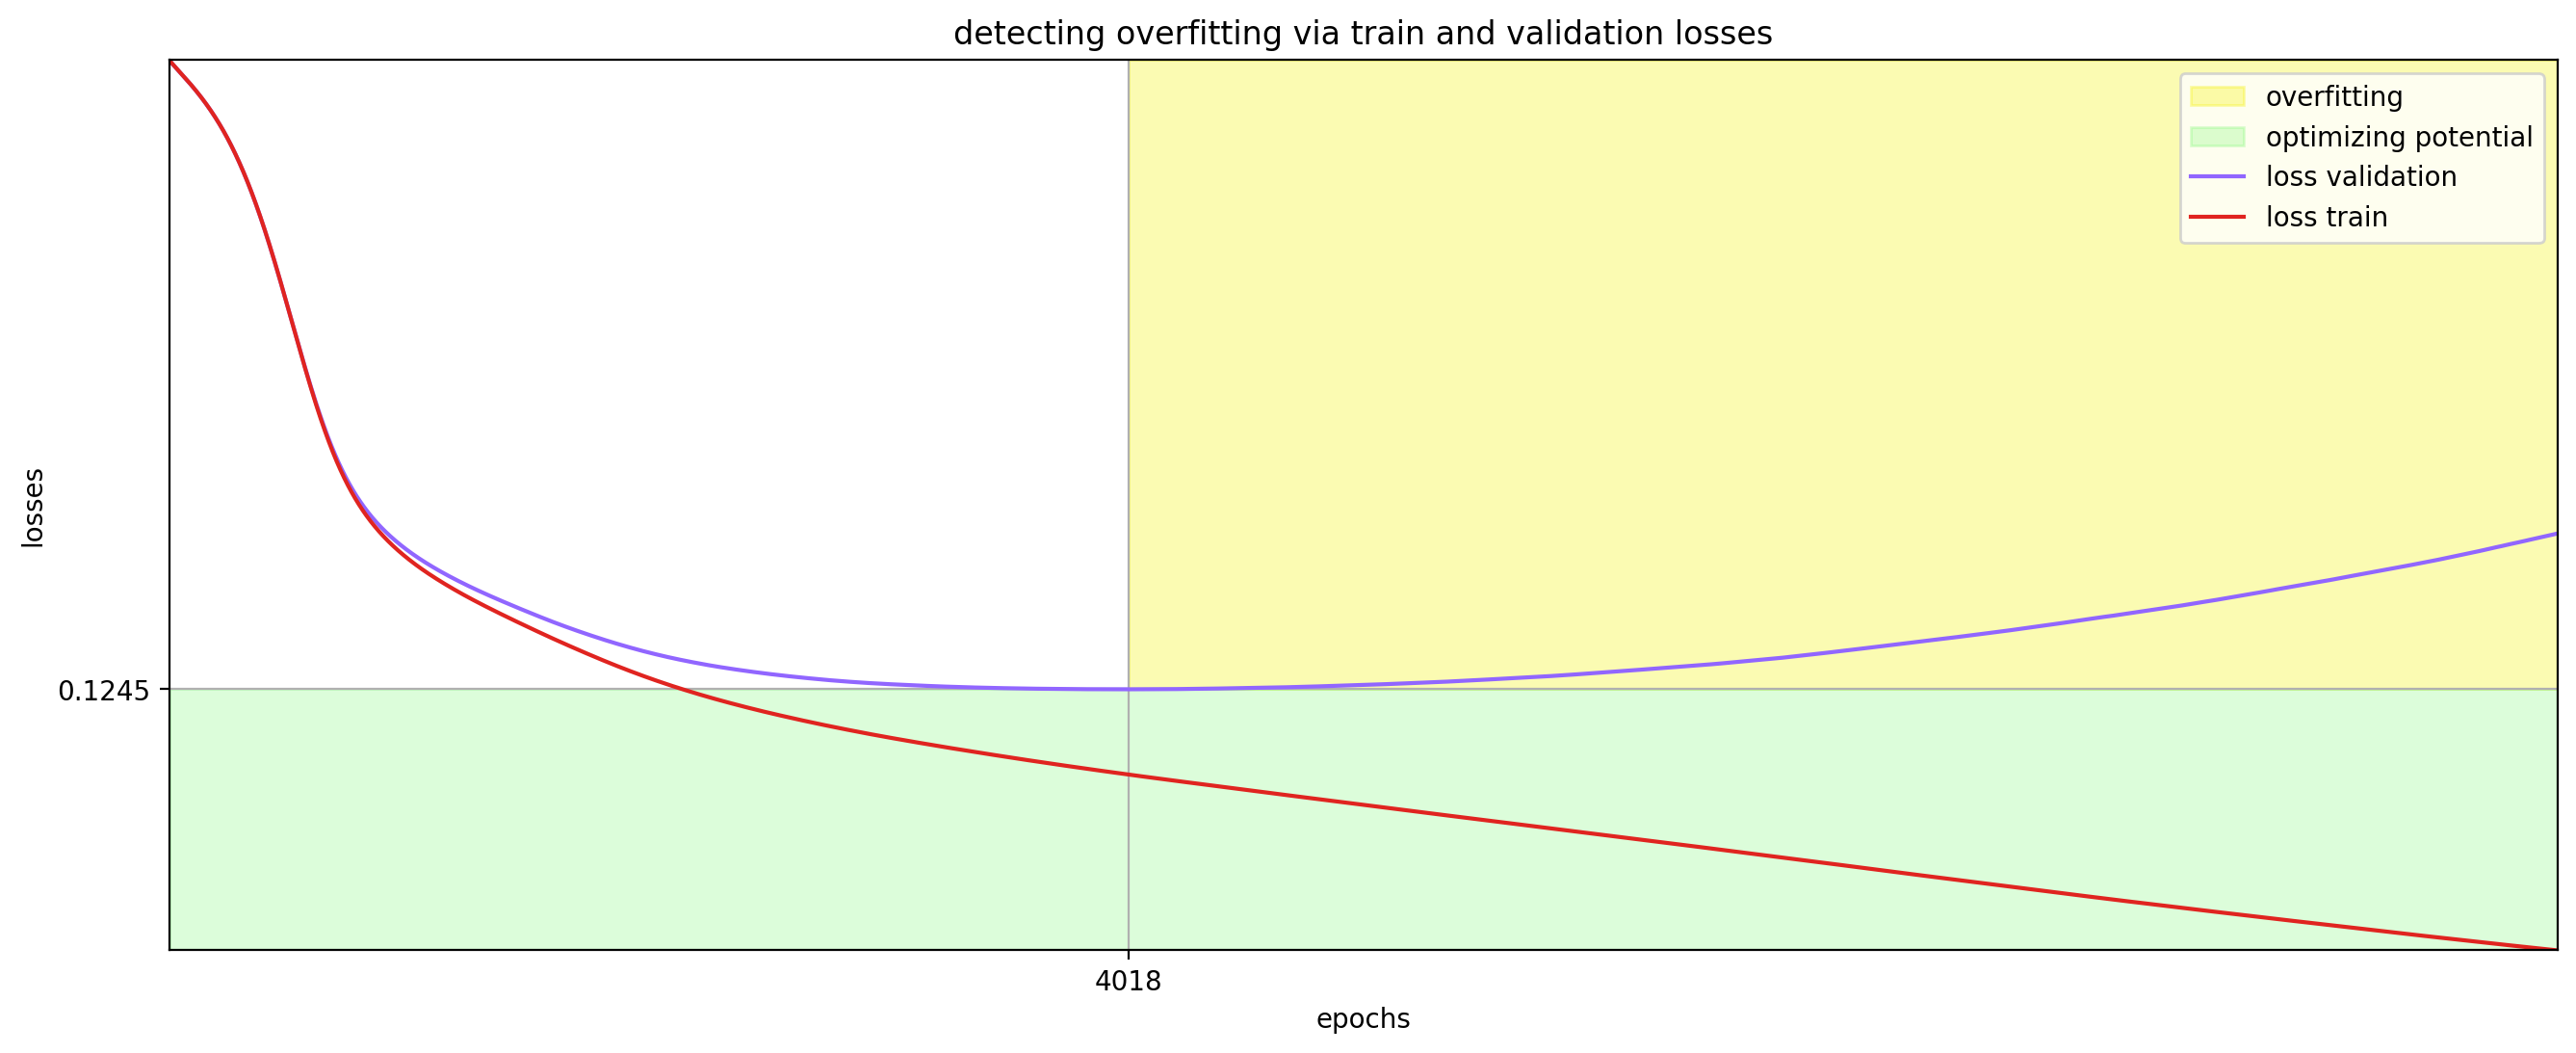

In [12]:
# visualize score
ymin = np.min(loss_train_arr)
ymax = np.max(loss_train_arr)
plt.figure(figsize=(16, 6), dpi=200)
plt.title("detecting overfitting via train and validation losses")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.axvspan(
    np.argmin(loss_val_arr),
    len(loss_val_arr),
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    1,
    color="#F5F200",
    alpha=0.3,
    label="overfitting",
)
plt.axvspan(
    0,
    len(loss_val_arr),
    0,
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    color="#52F748",
    alpha=0.2,
    label="optimizing potential",
)
plt.plot(loss_val_arr, color="#9166FF", label="loss validation")
plt.plot(loss_train_arr, color="#E02420", label="loss train")
plt.ylim(ymin, ymax)
plt.xlim(0, len(loss_val_arr))
plt.xticks([np.argmin(loss_val_arr)])
plt.yticks([np.min(loss_val_arr)])
plt.grid()
plt.legend()
plt.show()

Wie wir hier erkennen können, passiert nach einer bestimmten Zahl Iterationen overfitting, da der Loss Wert unseres Validierungsdatensatzes steigt, anstatt zu sinken. Um dies zu bekämpfen, muss das Modell selbst erkennen, dass Overfitting stattfindet und frühzeitig abbrechen. Dafür implemntieren wir ein Early Stopping, welches überprüft, ob der letzte Loss Wert kleiner ist, als der aktuelle. Falls dies der Fall ist, hört das Modell auf zu trainieren.

In [13]:
# create model
model = Gabonisator(X.shape[1], y.shape[1])

# define learning rate, loss function and optimizer
learning_rate = 0.00003
lossf = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss tracker
loss_train_arr = []
loss_val_arr = []

# define iterations and iterate (training)
n_epochs = 10000
for epoch in range(n_epochs):
    # forward prop
    y_pred = model(X_train_pytorch)
    # loss function
    loss_train = lossf(y_pred, y_train_pytorch)
    # back prop
    loss_train.backward()
    # update params with optimizer
    optim.step()
    # empty gradients
    optim.zero_grad()

    # forward prop val data
    y_pred_val = model(X_val_pytorch)
    # get loss of validation data
    loss_val = lossf(y_pred_val, y_val_pytorch)
    # save losses
    loss_train_arr.append(loss_train.item())
    loss_val_arr.append(loss_val.item())

    # loss val goes up too much -> EarlyStop
    if np.round(np.min(loss_val_arr), 4) != np.round(loss_val.item(), 4):
        print("Early Stopping!")
        break

    # print info every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(
            f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
        )

# print final data
with torch.no_grad():
    accuracy = (
        (model(X_val_pytorch).argmax(axis=1) == y_val_pytorch.argmax(axis=1)).sum() / y_val.shape[0]
    ).item()
    print("---")
    print(f"Final Run")
    print(
        f"Epoch: {(epoch): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f} | Score: {accuracy:.4f}"
    )


Epoch:   500/10000 | Loss train: 0.1873 | Loss val: 0.1871
Epoch:  1000/10000 | Loss train: 0.1481 | Loss val: 0.1489
Epoch:  1500/10000 | Loss train: 0.1376 | Loss val: 0.1396
Epoch:  2000/10000 | Loss train: 0.1289 | Loss val: 0.1326
Epoch:  2500/10000 | Loss train: 0.1221 | Loss val: 0.1280
Epoch:  3000/10000 | Loss train: 0.1175 | Loss val: 0.1257
Epoch:  3500/10000 | Loss train: 0.1139 | Loss val: 0.1244
Epoch:  4000/10000 | Loss train: 0.1108 | Loss val: 0.1239
Epoch:  4500/10000 | Loss train: 0.1078 | Loss val: 0.1238
Early Stopping!
---
Final Run
Epoch:  4571/10000 | Loss train: 0.1074 | Loss val: 0.1239 | Score: 0.6334


Jetzt visualisieren wir unsere Ergebnisse anhand der gleichen Visualisierung wie vorhin.

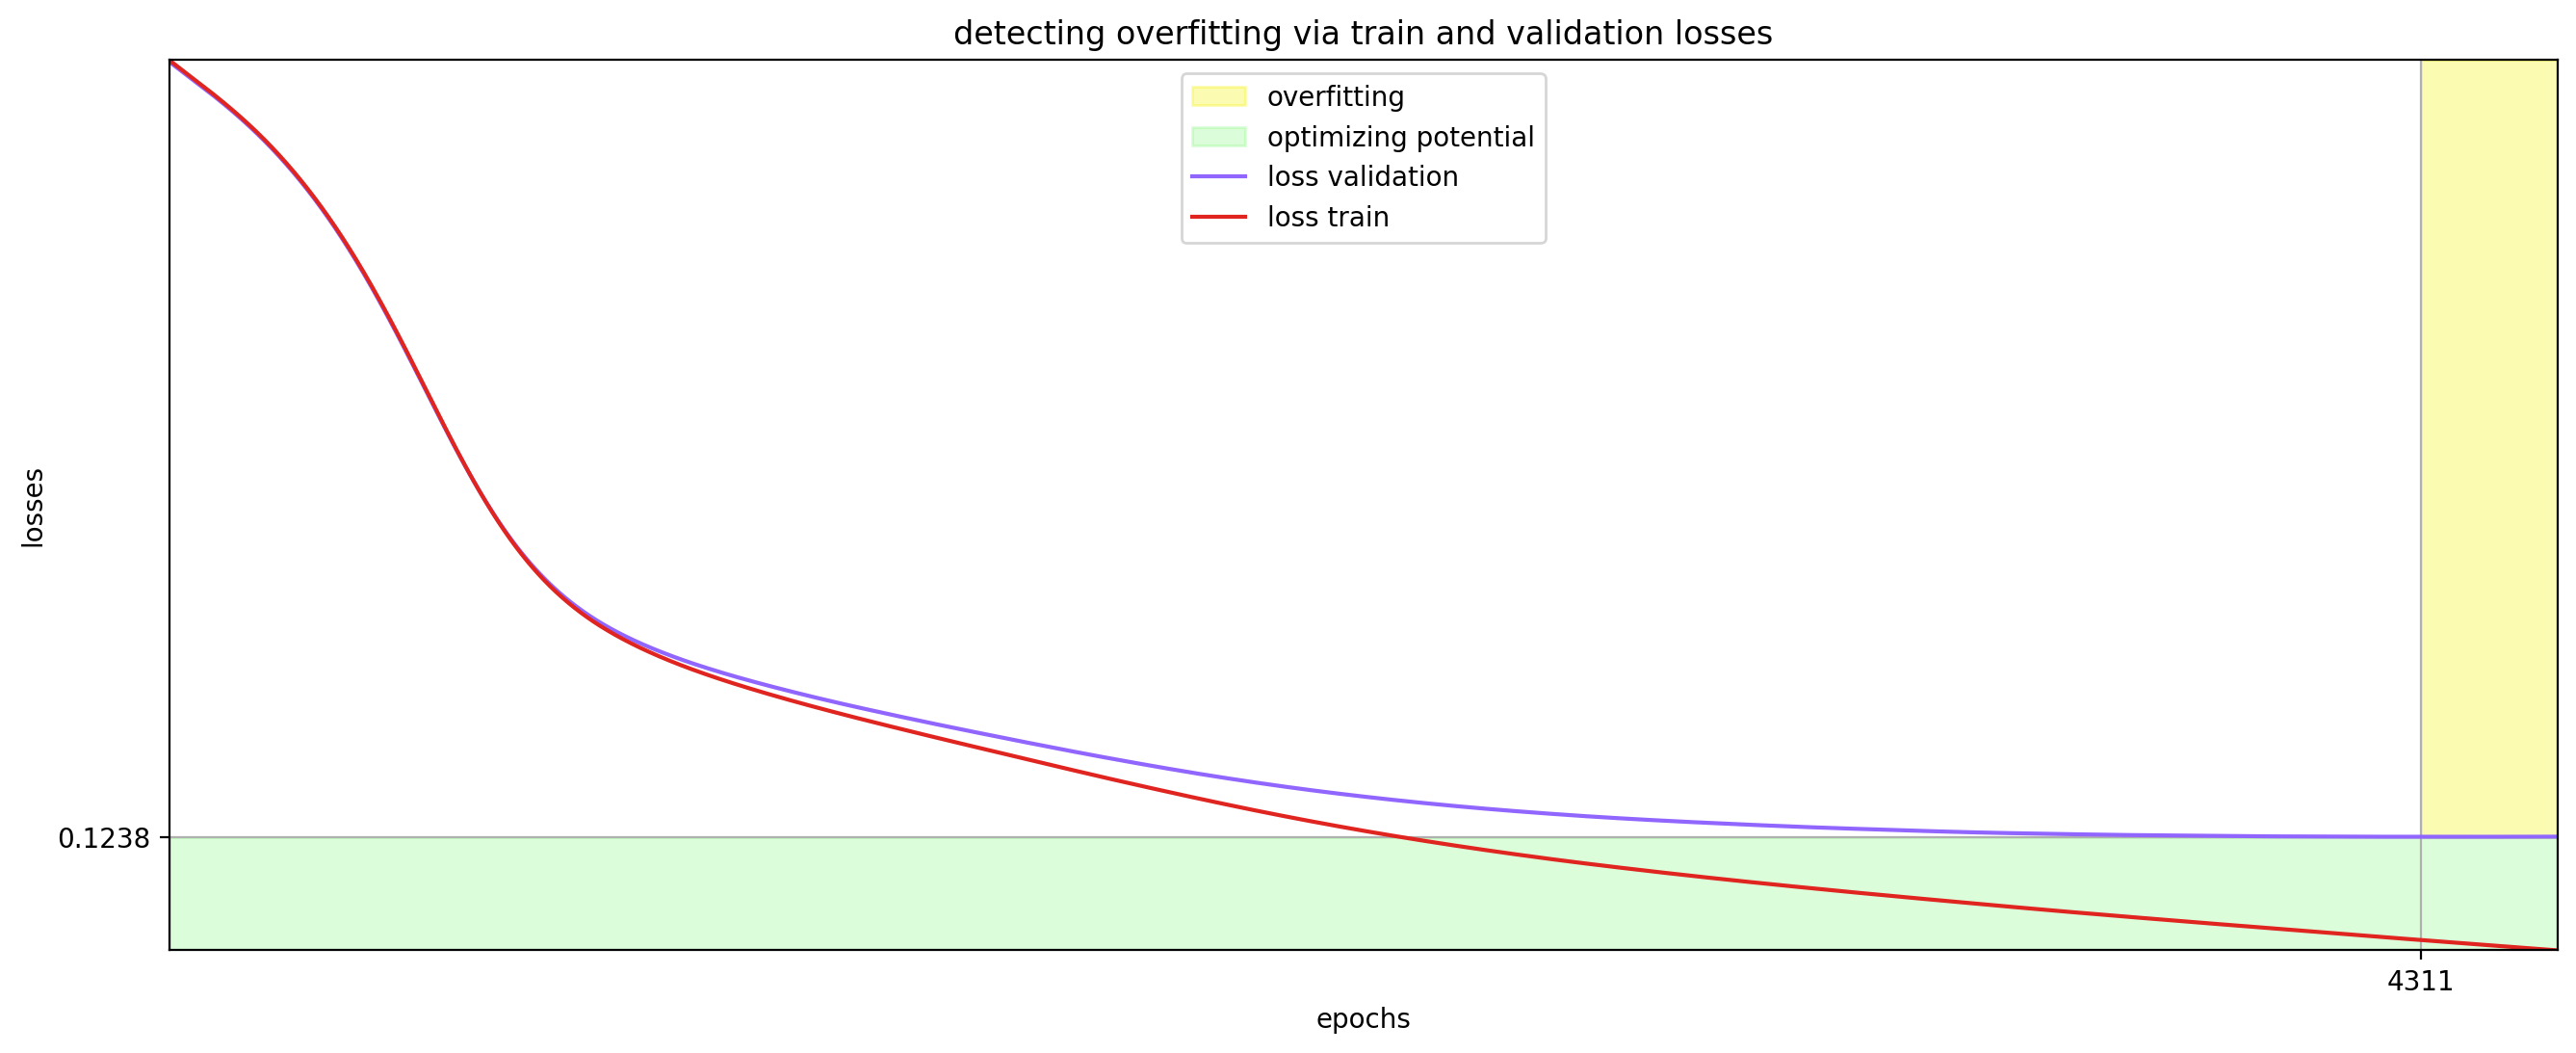

In [14]:
# visualize score
ymin = np.min(loss_train_arr)
ymax = np.max(loss_train_arr)
plt.figure(figsize=(16, 6), dpi=200)
plt.title("detecting overfitting via train and validation losses")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.axvspan(
    np.argmin(loss_val_arr),
    len(loss_val_arr),
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    1,
    color="#F5F200",
    alpha=0.3,
    label="overfitting",
)
plt.axvspan(
    0,
    len(loss_val_arr),
    0,
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    color="#52F748",
    alpha=0.2,
    label="optimizing potential",
)
plt.plot(loss_val_arr, color="#9166FF", label="loss validation")
plt.plot(loss_train_arr, color="#E02420", label="loss train")
plt.ylim(ymin, ymax)
plt.xlim(0, len(loss_val_arr))
plt.xticks([np.argmin(loss_val_arr)])
plt.yticks([np.min(loss_val_arr)])
plt.grid()
plt.legend()
plt.show()

In [15]:
def get_score_for_continous_multioutput(y_pred_continous, y_true, score_type):
    '''
    Compute different scores where y_pred is a continuous-multioutput

    Returns
    -------
    f1_score or precision_score or recall_scource from sklearn.metrics
    '''
    indices = [np.argmax(x) for x in y_pred_continous]
    zeros = [np.zeros(len(x)) for x in y_pred_continous]
    y_pred = list()
    for x, ind in zip(zeros, indices):
        x[ind] = 1
        y_pred.append(x)
    if score_type == "f1_weighted":
        return f1_score(y_true, y_pred, average="weighted", zero_division=1)
    elif score_type == "f1_micro":
        return f1_score(y_true, y_pred, average="micro", zero_division=1)
    elif score_type == "f1_macro":
        return f1_score(y_true, y_pred, average="macro", zero_division=1)
    elif score_type == "mcc_score":
        return matthews_corrcoef(y_true.argmax(axis=1), y_pred_continous.argmax(axis=1))
    elif score_type == "roc_auc_score":
        return roc_auc_score(y_true, y_pred, average="weighted")

In [16]:
y_pred_np = model(X_val_pytorch).detach().numpy()
y_val_np = y_val_pytorch.numpy()

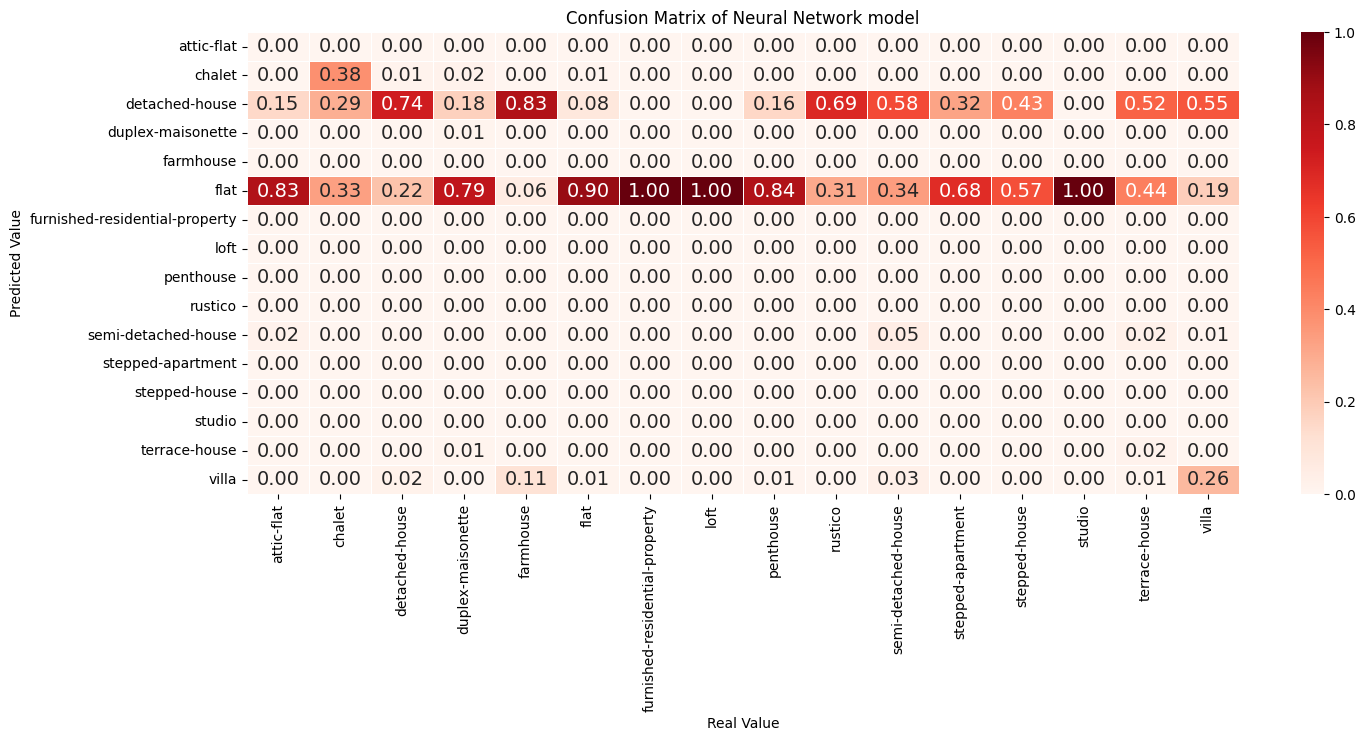

In [17]:
def plot_confusion_matrix(y_pred, y_val, modelname):
    types = y_cols.str.replace("type_", "")
    conf_matrix = confusion_matrix(y_pred.argmax(axis=1), y_val.argmax(axis=1), normalize="pred")
    conf_matrix = pd.DataFrame(conf_matrix, index=types, columns=types)
    _, ax = plt.subplots(figsize=(16,6))
    ax = sns.heatmap(conf_matrix, annot=True, fmt=".2f", linewidth=0.5, annot_kws={"size": 14}, cmap="Reds", ax = ax)
    ax.set(ylabel="Predicted Value", xlabel="Real Value", title = f"Confusion Matrix of {modelname} model")
    plt.show()

plot_confusion_matrix(y_pred_np, y_val_np, "Neural Network")

In [18]:
f1_weighted = get_score_for_continous_multioutput(y_pred_np, y_val_np, "f1_weighted")
f1_micro = get_score_for_continous_multioutput(y_pred_np, y_val_np, "f1_micro")
f1_macro = get_score_for_continous_multioutput(y_pred_np, y_val_np, "f1_macro")
mcc_score = get_score_for_continous_multioutput(y_pred_np, y_val_np, "mcc_score")
roc_score = get_score_for_continous_multioutput(y_pred_np, y_val_np, "roc_auc_score")

In [19]:
print(
    """
    Unser {} bricht jetzt frühzeitig ab und verhindert somit overfitting.\n
    Unser {} ist {}, unser {} ist {}, unser {} ist {},\n
    Unser {} ist mit diesem Modell ca. {},\n
    Unser {} ist mit diesem Modell ca. {}
    """.format(
        model.__class__.__name__,
        "F1 weighted", np.round(f1_weighted, 2), "F1 micro", np.round(f1_micro, 2), "F1 macro", np.round(f1_macro, 2),
        "MCC",
        np.round(get_score_for_continous_multioutput(y_pred_np, y_val_np, "mcc_score"), 2),
        "ROC AUC",
        np.round(get_score_for_continous_multioutput(y_pred_np, y_val_np, "roc_auc_score"), 2)
    )
)


    Unser Gabonisator bricht jetzt frühzeitig ab und verhindert somit overfitting.

    Unser F1 weighted ist 0.56, unser F1 micro ist 0.63, unser F1 macro ist 0.15,

    Unser MCC ist mit diesem Modell ca. 0.43,

    Unser ROC AUC ist mit diesem Modell ca. 0.7
    


## K Neighbors Classifier

Hier trainieren wir mehrere Modelle, welche wir anhand verschiedener Anzahl Neighbors erstellen. Für jedes Modell berechnen wir die Accuracy und speichern diese ab.

In [20]:
accuracies = np.array(
    [
        (i, KNeighborsClassifier(i).fit(X_train, y_train_labeled).score(X_val, y_val_labeled)) for i in tqdm(range(1, 50))
    ]
)

  0%|          | 0/49 [00:00<?, ?it/s]

Um zu entscheiden, wieviel Neighbors man für das Modell nehmen soll, visualisieren wir hier die Accuracy für jeden Wert.

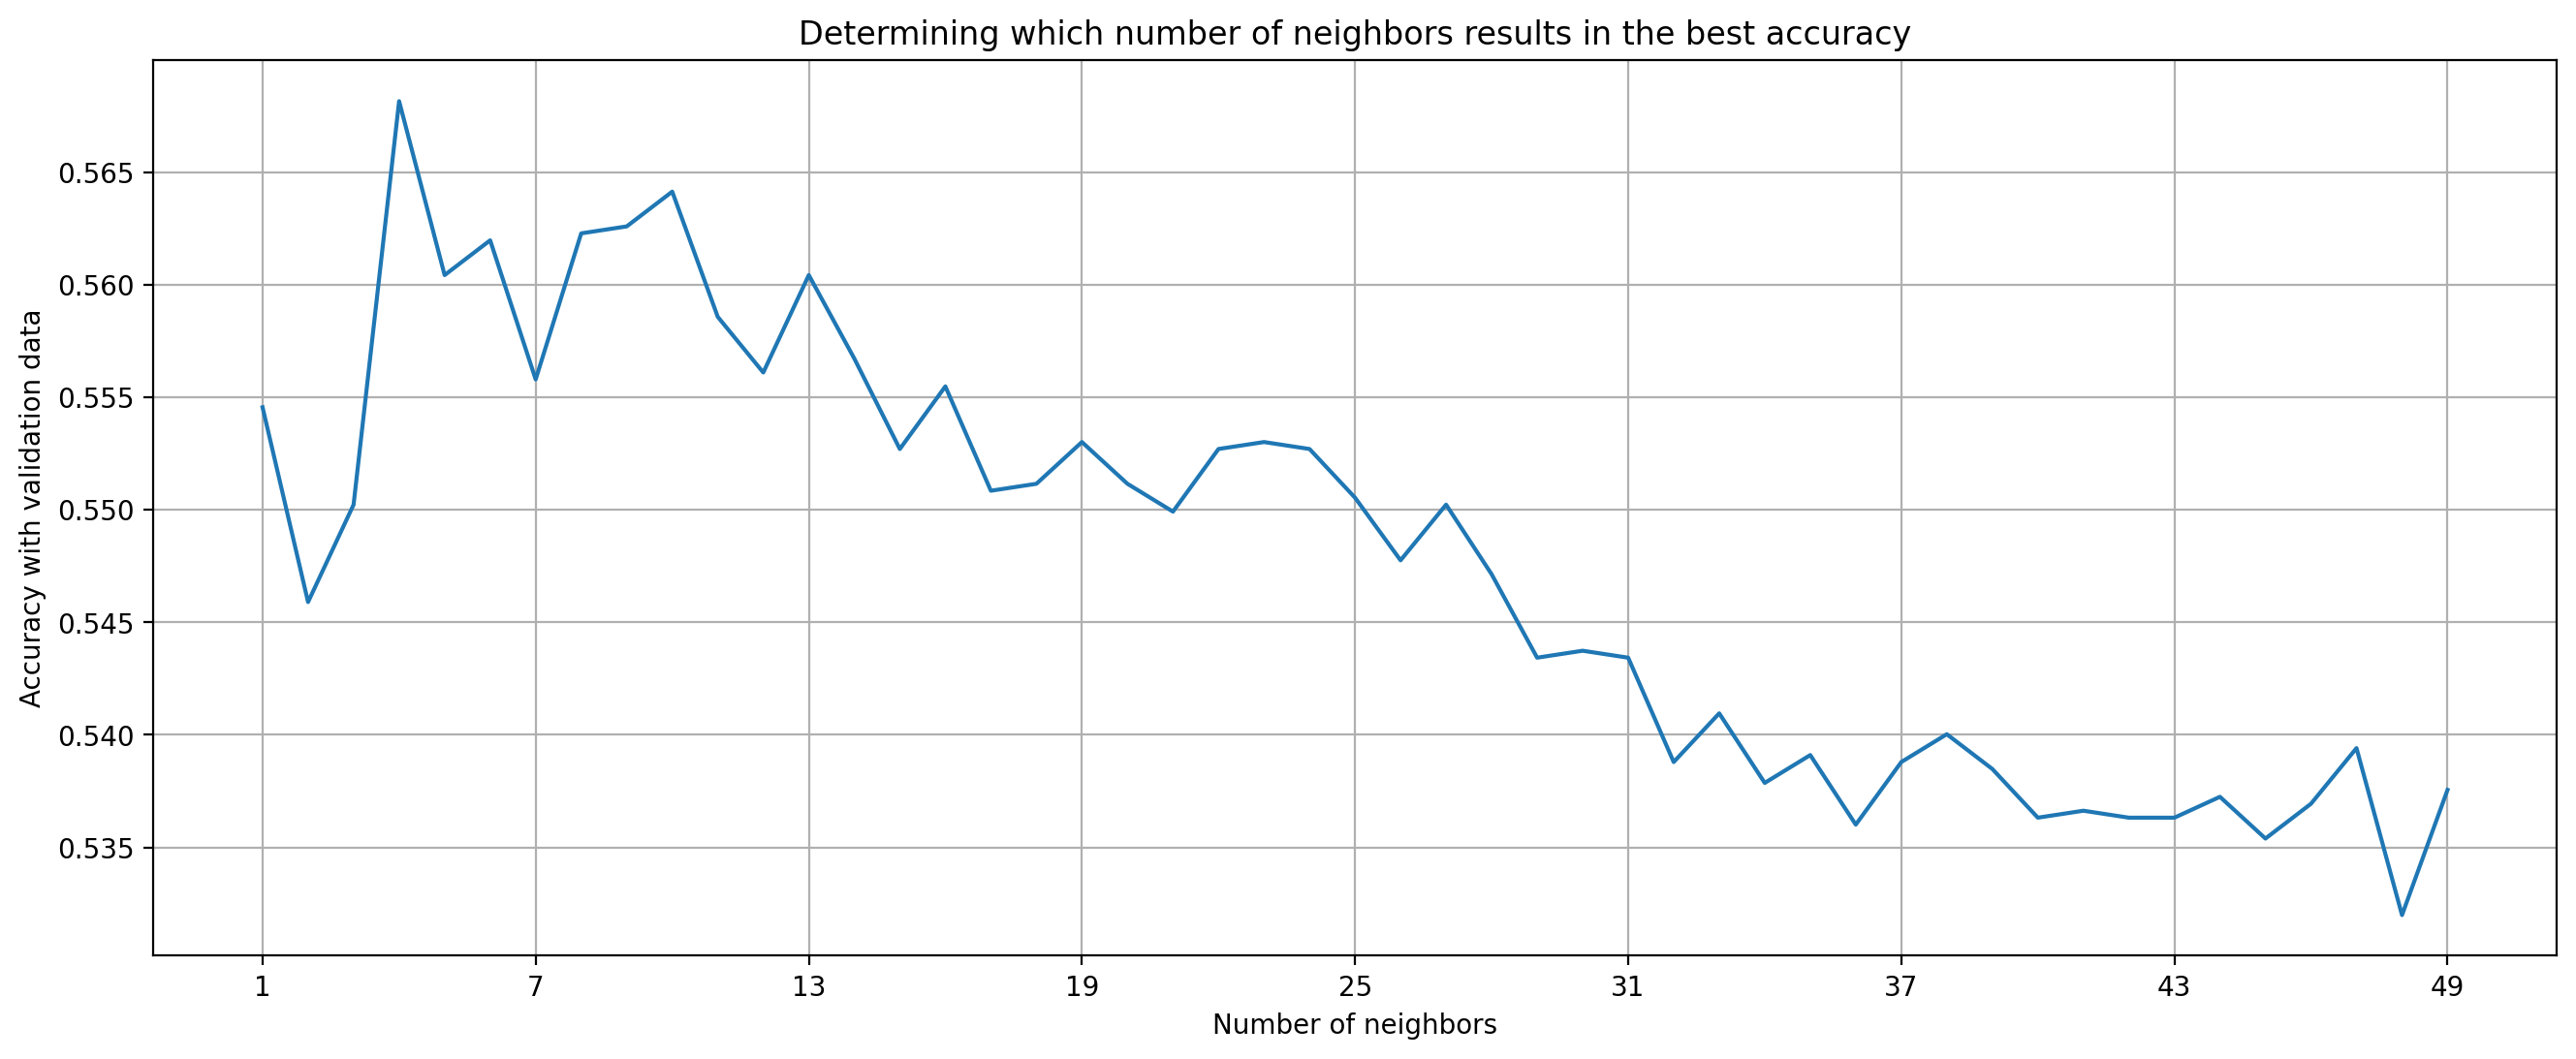

In [21]:
plt.figure(figsize=(16, 6), dpi=200)
plt.title("Determining which number of neighbors results in the best accuracy")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy with validation data")
plt.plot(accuracies[:,0], accuracies[:,1])
plt.xticks(np.linspace(1, 49, 9))
plt.grid()
plt.show()

In [22]:
neighbors = int(accuracies[:, :1].ravel()[np.argmax(accuracies[:, 1:])])
clf = OneVsRestClassifier(KNeighborsClassifier(neighbors)).fit(X_train, y_train_labeled)
accuracy = clf.score(X_val, y_val_labeled)
f1_weighted = f1_score(y_val_labeled, clf.predict(X_val), average="weighted", zero_division=1)
f1_micro = f1_score(y_val_labeled, clf.predict(X_val), average="micro", zero_division=1)
f1_macro = f1_score(y_val_labeled, clf.predict(X_val), average="macro", zero_division=1)
y_true = OneHotEncoder().fit_transform(y_val_labeled.values.reshape(-1, 1)).toarray()
y_pred = OneHotEncoder().fit_transform(clf.predict(X_val).reshape(-1, 1)).toarray()
roc_score = roc_auc_score(y_true, y_pred)
mcc_score = get_score_for_continous_multioutput(y_pred, y_true, "mcc_score")

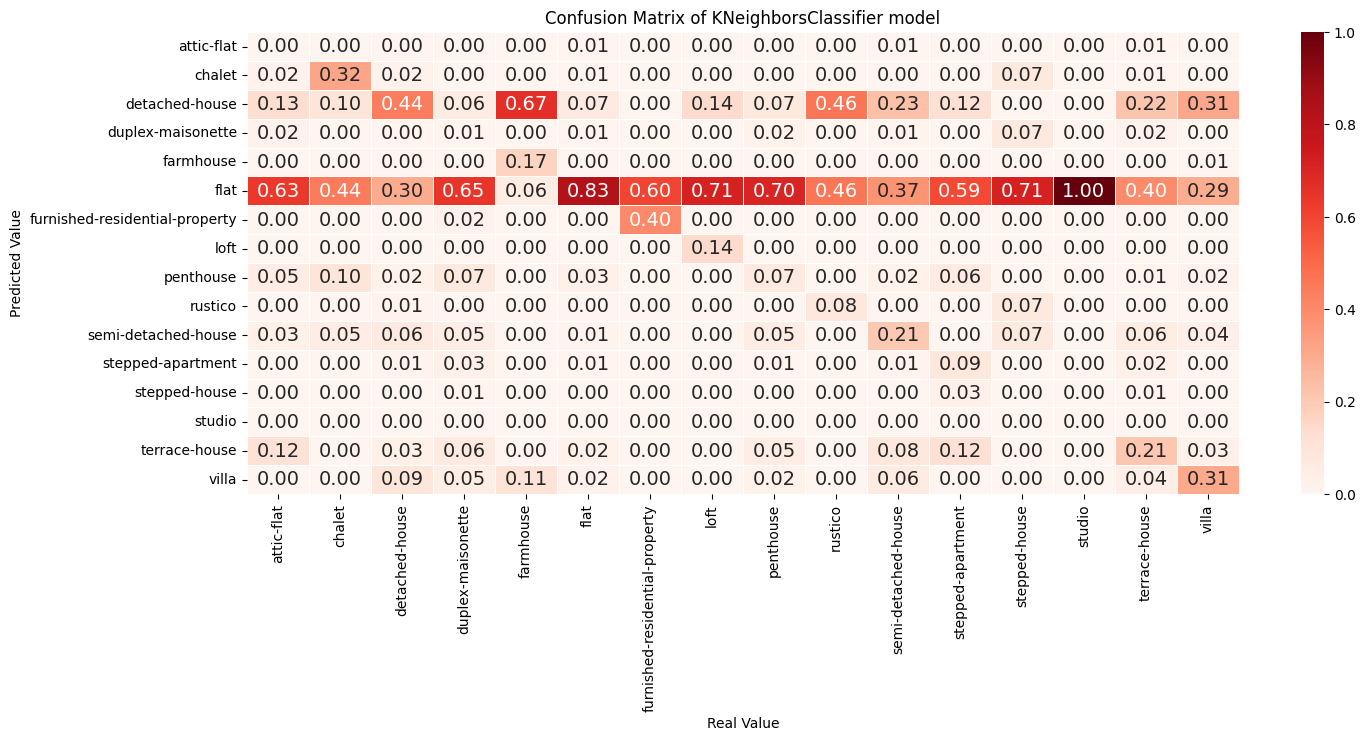

In [23]:
def plot_confusion_matrix_labeled(y_pred, y_val, modelname):
    types = y_cols.str.replace("type_", "")
    conf_matrix = confusion_matrix(y_pred, y_val, normalize="pred")
    conf_matrix = pd.DataFrame(conf_matrix, index=types, columns=types)
    _, ax = plt.subplots(figsize=(16,6))
    ax = sns.heatmap(conf_matrix, annot=True, fmt=".2f", linewidth=0.5, annot_kws={"size": 14}, cmap="Reds", ax = ax)
    ax.set(ylabel="Predicted Value", xlabel="Real Value", title = f"Confusion Matrix of {modelname} model")
    plt.show()

plot_confusion_matrix_labeled(clf.predict(X_val), y_val_labeled, "KNeighborsClassifier")

In [24]:
print(
    '''
    Aus dem obigen Plot kann man sehen, welches Modell die höchste Accuracy hat.\n
    Wir setzen für den {} die Anzhal {} = {}\n
    und erhalten damit eine {} von ca. {},\n
    Unser {} ist {}, unser {} ist {}, unser {} ist {},\n
    Unsere {} ist mit diesem Modell ca. {},\n
    Unser {} ist mit diesem Modell ca. {}
    '''.format(
        model.__class__.__name__,
        "neighbors",
        neighbors,
        "Accuracy",
        np.round(accuracy, 2),
        "F1 weighted", np.round(f1_weighted, 2), "F1 micro", np.round(f1_micro), "F1 macro", np.round(f1_macro),
        "MCC",
        np.round(mcc_score, 2),
        "ROC AUC",
        np.round(roc_score, 2)
    )
)


    Aus dem obigen Plot kann man sehen, welches Modell die höchste Accuracy hat.

    Wir setzen für den Gabonisator die Anzhal neighbors = 4

    und erhalten damit eine Accuracy von ca. 0.55,

    Unser F1 weighted ist 0.52, unser F1 micro ist 1.0, unser F1 macro ist 0.0,

    Unsere MCC ist mit diesem Modell ca. 0.29,

    Unser ROC AUC ist mit diesem Modell ca. 0.57
    


## Random Forest Classifier

Um zu entscheiden welche Parameter in Frage kommen, probieren wir es zuerst mit "RandomizedSearchCV" und danach mit "GridSearchCV"

Random Hyperparameter Grid:<br />
Wir erstellen zuerst einen Hyperparameter Grid,<br />
und wählen nach dem Zufallsprinzip Kombinationen, um eine breite Palette von Werten auszuprobieren.<br />
Danach instanzieren wir random search auf unsere Daten und wählen n_iter für die Nummer der verschiedenen<br />
Kombinationen sowie cv für die Nummer der folds für Cross Validation.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
# Nummer der Bäume im Random Forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
# Anzahl der Features, die bei jedem Split berücksichtigt werden
max_features = ['sqrt']
# Maximale Anzahl an Ebenen im Baum
max_depth = [int(x) for x in np.linspace(1, 11, num = 1)]
max_depth.append(None)
# Mindestanzahl an Samples, die benötigt werden, um einen Knoten zu splitten
min_samples_split = np.linspace(2, 10, 9).astype(int)
# Mindestanzahl an Samples, die benötigt werden, um einen Blattknoten zu erstellen
min_samples_leaf = np.linspace(1, 20, 20).astype(int)
# Methode, um Samples für das Training jedes Baumes auszuwählen
bootstrap = [True, False]
# Erstelle das zufällige Grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
# Verwende das zufällige Grid, um die besten Hyperparameter zu finden
# Erstelle zuerst das Basismodell, das angepasst werden soll
random_forest_classifier = RandomForestClassifier()
# Zufällige Suche nach Parametern, mit 3-facher Kreuzvalidierung,
# Suche über 100 verschiedene Kombinationen und verwende alle verfügbaren Kerne
rfc_random = RandomizedSearchCV(
    estimator = random_forest_classifier,
    param_distributions = random_grid,
    n_iter = 50, 
    cv = 2, 
    verbose=0, 
    random_state=42,
    n_jobs = -1,
    scoring = "f1_macro"
)
# Passe das zufällige Suchmodell an
rfc_random.fit(X_train, y_train_labeled)

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': [10, 14, 18, 23, 27, 32,
                                                         36, 41, 45, 50]},
                   random_state=42, scoring='f1_macro')

In [26]:
rfc_random.best_params_

{'n_estimators': 36,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

Grid Search mit Cross Validation

In [27]:
from sklearn.model_selection import GridSearchCV
# Erstelle das Parametergrid basierend auf den Ergebnissen der zufälligen Suche
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [1, None],
    'max_features': ["sqrt"],
    'min_samples_leaf': np.linspace(1, 10, 5).astype(int),
    'min_samples_split': np.linspace(2, 20, 5).astype(int),
    'n_estimators': np.linspace(10, 100, 10).astype(int)
}
# Erstelle ein Basismodell
rf = RandomForestClassifier()
# Erstelle das Grid-Suchmodell
grid_search = GridSearchCV(
    estimator = rf, 
    param_grid = param_grid, 
    cv = 2, 
    n_jobs = -1, 
    verbose = 0,
    scoring = "f1_macro"
)
# Passe die Grid-Suche an die Daten an
grid_search.fit(X_train, y_train_labeled)

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [1, None],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': array([ 1,  3,  5,  7, 10]),
                         'min_samples_split': array([ 2,  6, 11, 15, 20]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='f1_macro')

In [28]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

Berechne die höchste Accuracy für beide Hyperparameter Optimierungen

In [29]:
rfc_random_accuracy = rfc_random.score(X_val, y_val_labeled)
grid_accuracy = grid_search.best_estimator_.score(X_val, y_val_labeled)

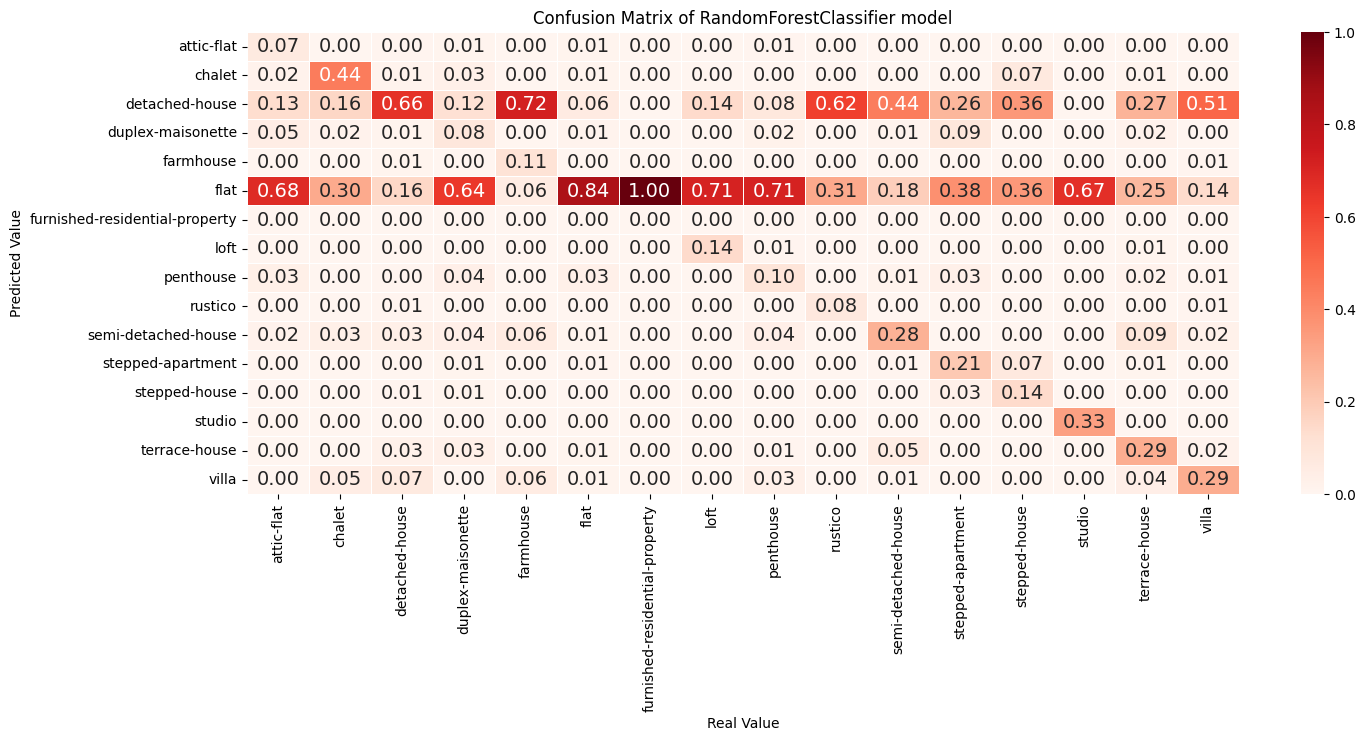

In [30]:
plot_confusion_matrix_labeled(grid_search.best_estimator_.predict(X_val), y_val_labeled, "RandomForestClassifier")

Printe alle erforderlichen Scores

In [31]:
n_estimators = max(grid_search.best_params_["n_estimators"], rfc_random.best_params_["n_estimators"])
model = grid_search.best_estimator_
accuracy = max(rfc_random_accuracy, grid_accuracy)
f1_weighted = f1_score(y_val_labeled, model.predict(X_val), average="weighted", zero_division=1)
f1_micro = f1_score(y_val_labeled, model.predict(X_val), average="micro", zero_division=1)
f1_macro = f1_score(y_val_labeled, model.predict(X_val), average="macro", zero_division=1)
y_true = OneHotEncoder().fit_transform(y_val_labeled.values.reshape(-1, 1)).toarray()
y_pred = OneHotEncoder().fit_transform(model.predict(X_val).reshape(-1, 1)).toarray()
roc_score = roc_auc_score(y_true, y_pred)
mcc_score = get_score_for_continous_multioutput(y_pred, y_true, "mcc_score")

In [32]:
print(
    '''
    Aus den obigen Überlegungen setzen wir\n 
    für den {} den Parameter {} = {} (number of trees in the model)\n
    und erhalten damit eine {} von ca. {},\n
    Unser {} ist {}, unser {} ist {}, unser {} ist {},\n
    unsere {} ist mit diesem Modell ca. {},\n
    unser {} ist mit diesem Modell ca. {}
    '''.format(
        model.__class__.__name__,
        "n_estimators",
        n_estimators,
        "Accuracy",
        np.round(accuracy, 2),
        "F1 weighted", np.round(f1_weighted, 2), "F1 micro", np.round(f1_micro, 2), "F1 macro", np.round(f1_macro, 2),
        "MCC",
        np.round(mcc_score, 2),
        "ROC AUC",
        np.round(roc_score, 2)
    )
)


    Aus den obigen Überlegungen setzen wir
 
    für den RandomForestClassifier den Parameter n_estimators = 100 (number of trees in the model)

    und erhalten damit eine Accuracy von ca. 0.62,

    Unser F1 weighted ist 0.6, unser F1 micro ist 0.62, unser F1 macro ist 0.28,

    unsere MCC ist mit diesem Modell ca. 0.38,

    unser ROC AUC ist mit diesem Modell ca. 0.56
    


## HistGradientBoostClassifier

In [33]:
param_grid = {
    'l2_regularization': np.linspace(0.1, 0.5, 24),
}

grid_search = GridSearchCV(
    estimator = HistGradientBoostingClassifier(),
    param_grid = param_grid,
    cv = 2,
    n_jobs = -1,
    verbose = 0,
    scoring = "f1_macro"
)

grid_search.fit(X_train, y_train_labeled)

model = grid_search.best_estimator_

In [34]:
grid_search.best_params_

{'l2_regularization': 0.15217391304347827}

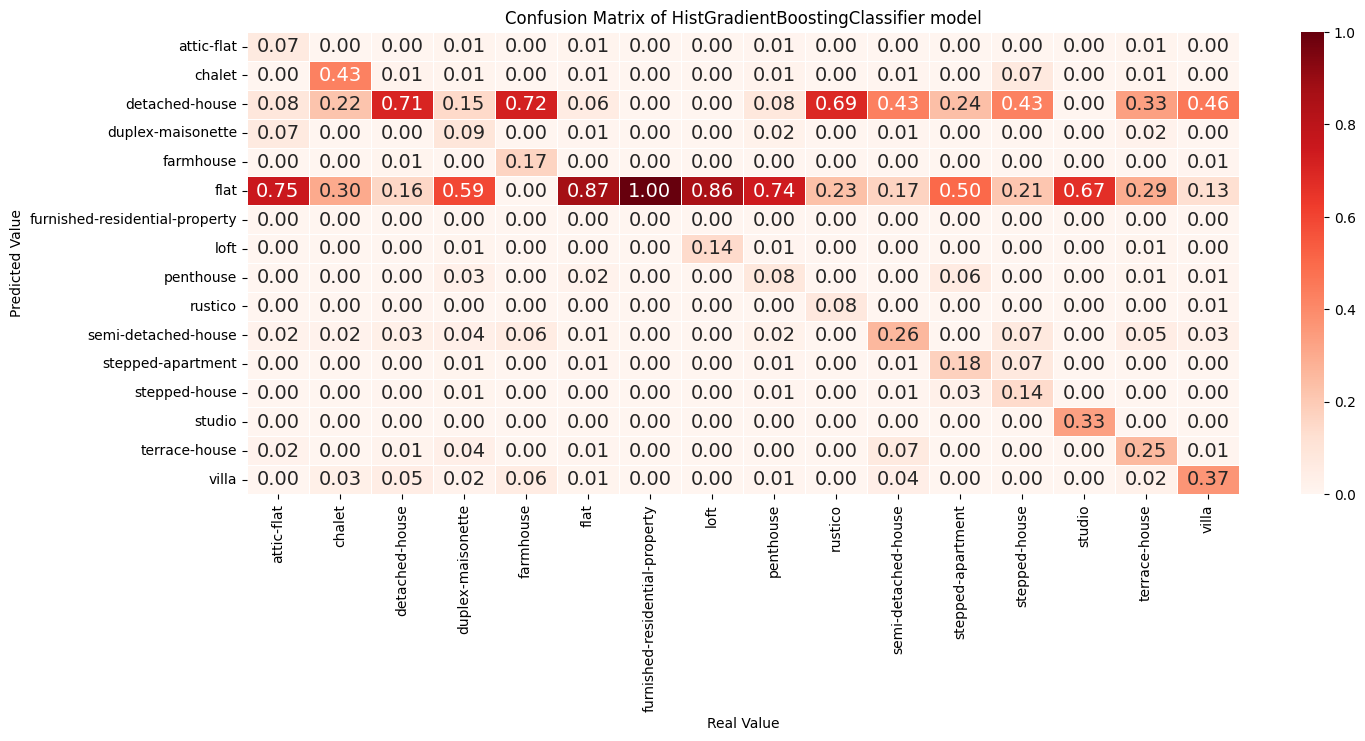

In [35]:
plot_confusion_matrix_labeled(model.predict(X_val), y_val_labeled, "HistGradientBoostingClassifier")

In [36]:
accuracy = model.score(X_val, y_val_labeled)
f1_weighted = f1_score(y_val_labeled, model.predict(X_val), average="weighted", zero_division=1)
f1_micro = f1_score(y_val_labeled, model.predict(X_val), average="micro", zero_division=1)
f1_macro = f1_score(y_val_labeled, model.predict(X_val), average="macro", zero_division=1)
y_true = OneHotEncoder().fit_transform(y_val_labeled.values.reshape(-1, 1)).toarray()
y_pred = OneHotEncoder().fit_transform(model.predict(X_val).reshape(-1, 1)).toarray()
roc_score = roc_auc_score(y_true, y_pred)
mcc_score = get_score_for_continous_multioutput(y_pred, y_true, "mcc_score")

In [37]:
print(
    '''
    Aus den obigen Überlegungen setzen wir\n 
    den {} ein\n
    und erhalten damit eine {} von ca. {},\n
    Unser {} ist {}, unser {} ist {}, unser {} ist {},\n
    unsere {} ist mit diesem Modell ca. {},\n
    unser {} ist mit diesem Modell ca. {}
    '''.format(
        model.__class__.__name__,
        "Accuracy",
        np.round(accuracy, 2),
        "F1 weighted", np.round(f1_weighted, 2), "F1 micro", np.round(f1_micro), "F1 macro", np.round(f1_macro),
        "MCC",
        np.round(mcc_score, 2),
        "ROC AUC",
        np.round(roc_score, 2)
    )
)


    Aus den obigen Überlegungen setzen wir
 
    den HistGradientBoostingClassifier ein

    und erhalten damit eine Accuracy von ca. 0.65,

    Unser F1 weighted ist 0.62, unser F1 micro ist 1.0, unser F1 macro ist 0.0,

    unsere MCC ist mit diesem Modell ca. 0.41,

    unser ROC AUC ist mit diesem Modell ca. 0.56
    
